In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import h5py
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
import glob
import os
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
from torchvision.models import alexnet, vgg16, resnet152, resnet18, vgg19

%matplotlib inline

import matplotlib.pyplot as plt
import math

import torch.nn.functional as nnf
from torch.utils.data import random_split
from torch.optim import SGD 
from torch.distributions import constraints
import torchvision as torchv
import torchvision.transforms as torchvt
import pickle

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Function for moving tensor or model to GPU
def cuda(xs):
    if torch.cuda.is_available():
        if not isinstance(xs, (list, tuple)):
            return xs.cuda()
        else:
            return [x.cuda() for x in xs]
    else:
        return xs

# Custom class for defining dataset for training with augmentation
class Dataset_Hdf5(Dataset):

    def __init__(self, path, data_type):
        """ Intialize the dataset
        """
        self.path = path
        self.file = h5py.File(path, 'r')
        self.images = self.file['x_{}'.format(data_type)]
        self.labels = self.file['y_{}'.format(data_type)]
                
        self.len = self.images.shape[0]
        if data_type == 'train':
            self.transform = transforms.Compose([
#                                               transforms.ToPILImage(),
#                                               transforms.RandomRotation((0, 360)),
#                                               transforms.RandomHorizontalFlip(),
#                                               transforms.RandomVerticalFlip(),
                                              transforms.ToTensor()])
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        # unsqueeze adds dimension to image -> converts to 1x224x224 since we don't have rgb
        return self.transform(self.images[index].astype('float32')), \
                torch.tensor(self.labels[index], dtype=torch.long)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [8]:
hb_train_loader = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih.hdf5', 'train'), 
                                                batch_size=512, shuffle=True)
hb_test_loader = torch.utils.data.DataLoader(Dataset_Hdf5('/home/asif/heartbeat/hb_data_mit_bih.hdf5', 'test'), 
                                                batch_size=256, shuffle=False)

In [4]:
alex_net = alexnet(pretrained=True)
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [48]:
alex_net = alexnet(pretrained=True)
alex_net.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(in_features=9216, out_features=4096, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=4096, out_features=2048, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=2048, out_features=1024, bias=True),
                nn.ReLU(inplace=True),
                nn.Linear(in_features=1024, out_features=5, bias=True)
               )

for param in alex_net.parameters():
    param.requires_grad = False # frozen layer


# Now we make later layers trainable
for param in alex_net.avgpool.parameters():
    param.requires_grad = True
for param in alex_net.classifier.parameters():
    param.requires_grad = True

# res_net.fc = nn.Sequential(
#                 nn.Linear(in_features=num_ftrs, out_features=256, bias=False),
#                 nn.ReLU(),
#                 nn.Linear(in_features=256, out_features=128, bias=True),
#                 nn.ReLU(),
#                 n

In [49]:
alex_net.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [50]:
optimizer_alex_net = torch.optim.Adam(alex_net.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()

In [53]:
def train(net, train_loader, criterion, optimizer, num_epochs=25):
    net.train()
    train_acc_max = 0
    test_acc_max = 0

#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()

        total = 0
        correct = 0
   
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = cuda(data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.expand(-1, 3, -1, -1))
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        
#         scheduler.step()
        
        print('End of epoch {}, Loss {}'.format(epoch + 1, running_loss / len(train_loader)))
        
        train_acc = correct / total
        print('Train accuracy: {}'.format(train_acc))
        test_acc, all_true, all_pred = test(net, hb_test_loader)
        print('Test accuracy: {}'.format(test_acc))
        print(classification_report(all_true, all_pred, target_names=['N', 'S', 'V', 'F', 'Q']))
        
        # Saving best checkpoint based on performance on test data
#         if train_acc > train_acc_max:
#             train_acc_max = train_acc
#             save_checkpoint(epoch + 1, net, optimizer, train_acc, test_acc, net_name, 'train')
            
#         if test_acc > test_acc_max:
#             test_acc_max = test_acc
#             save_checkpoint(epoch + 1, net, optimizer, train_acc, test_acc, net_name, 'test')

    print('Finished Training')
    
def test(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    all_true = []
    all_pred = []
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = cuda(data)
            all_true.extend(labels.cpu().tolist())
            outputs = net(images.expand(-1, 3, -1, -1))
            _, predicted = torch.max(outputs, 1)
            all_pred.extend(predicted.cpu().tolist())
#             predicted = predicted.float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
#     print('Accuracy of the network on the images: %d %%' % (100 * acc))
    return acc, all_true, all_pred

In [54]:
train(alex_net, hb_train_loader, criterion, optimizer_alex_net, 10)

End of epoch 1, Loss 0.1267867919360829
Train accuracy: 0.963668136235923
Test accuracy: 0.9513064133016627
              precision    recall  f1-score   support

           N       0.95      1.00      0.97     18118
           S       0.94      0.58      0.72       556
           V       1.00      0.63      0.77      1448
           F       0.79      0.25      0.38       162
           Q       1.00      0.90      0.95      1608

   micro avg       0.95      0.95      0.95     21892
   macro avg       0.93      0.67      0.76     21892
weighted avg       0.95      0.95      0.95     21892

End of epoch 2, Loss 0.1082158574704514
Train accuracy: 0.9683395390273432
Test accuracy: 0.971405079481089
              precision    recall  f1-score   support

           N       0.97      1.00      0.98     18118
           S       0.97      0.56      0.71       556
           V       0.97      0.85      0.91      1448
           F       0.74      0.69      0.72       162
           Q       0.99 

In [55]:
test_acc, all_true, all_pred = test(alex_net, hb_test_loader)

In [56]:
test_acc

0.9801297277544309

In [67]:
with open ('all_labels.pkl', 'wb') as f:
    pickle.dump(all_true, f)

In [68]:
with open ('all_preds.pkl', 'wb') as f:
    pickle.dump(all_pred, f)

In [2]:
with open ('all_labels.pkl', 'rb') as f:
    all_true = pickle.load(f)

In [3]:
with open ('all_preds.pkl', 'rb') as f:
    all_pred = pickle.load(f)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18027    49    13     4    25]
 [  140   401    14     1     0]
 [   80     7  1333    17    11]
 [   31     0    21   110     0]
 [   21     0     1     0  1586]]
Normalized confusion matrix
[[9.95e-01 2.70e-03 7.18e-04 2.21e-04 1.38e-03]
 [2.52e-01 7.21e-01 2.52e-02 1.80e-03 0.00e+00]
 [5.52e-02 4.83e-03 9.21e-01 1.17e-02 7.60e-03]
 [1.91e-01 0.00e+00 1.30e-01 6.79e-01 0.00e+00]
 [1.31e-02 0.00e+00 6.22e-04 0.00e+00 9.86e-01]]


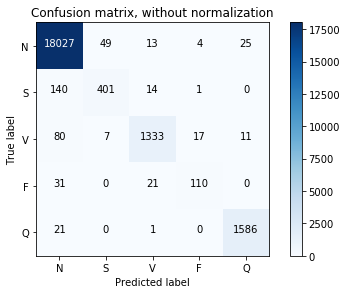

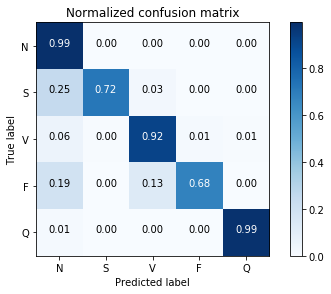

In [35]:
# Compute confusion matrix
class_names=['N', 'S', 'V', 'F', 'Q']

cnf_matrix = confusion_matrix(all_true, all_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()